In [116]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision
from torchvision.datasets import MNIST, FashionMNIST ,CIFAR10
from torchvision.models import resnet18
from torchvision.transforms import *
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
import itertools
import os
import sys
sys.path.append("..")
from vos import VOS

# Load ID (MNIST) and OOD (Fashion MNIST) datasets

In [2]:
id_dataset = MNIST(root = "~/datasets/MNIST", train = False)
ood_dataset = FashionMNIST(root = "~/datasets/FashionMNIST", train = False)
transform = Compose([lambda x: x.float(), Normalize((0.1307,), (0.3081,))])

samples = id_dataset.data
targets = id_dataset.targets
id_data = TensorDataset(transform(samples).unsqueeze(1), targets)

ood_samples = ood_dataset.data
ood_targets = ood_dataset.targets
ood_data = TensorDataset(transform(ood_samples).unsqueeze(1), ood_targets)

id_loader = DataLoader(id_data, batch_size = 1024, shuffle = True)
ood_loader = DataLoader(ood_data, batch_size = 1024, shuffle = True)

In [3]:
model = torch.load("../model_weights/vos_model.pt", weights_only = False)

In [4]:
class OODDetector(nn.Module):
    def __init__(self, latent_dim = 512):
        super().__init__()
        self.latent_dim = latent_dim
        self.mlp = nn.Sequential(nn.Linear(1, latent_dim),
                                 nn.ReLU(),
                                 nn.Linear(latent_dim, 1))
    
    def forward(self, x):
        out = self.mlp(x)
        return out
    
ood_detector = OODDetector(latent_dim = 512)

In [5]:
ood_detector = torch.load("../model_weights/vos_ood_detector.pt", weights_only = False)

In [6]:
def accuracy(pred, true):
    return torch.sum(pred == true)/true.shape[0]

In [7]:
id_batch = next(iter(id_loader))
id_samples, id_targets = id_batch

# Model is pretty good at classification

In [8]:
pred = torch.argmax(model(id_samples), dim = 1)
true = id_targets
acc = accuracy(pred, true)
print(acc)

tensor(0.9883)


# Want to see that the ID and OOD samples have different probabilities. I need to work this out a little bit more, to make sure that it is doing what we want

In [9]:
id_logits = model(id_samples)
id_energy = -torch.logsumexp(id_logits, dim = 1).unsqueeze(1)
id_scores = ood_detector(id_energy)
id_prob = torch.exp(-id_scores)/(1 + torch.exp(-id_scores))

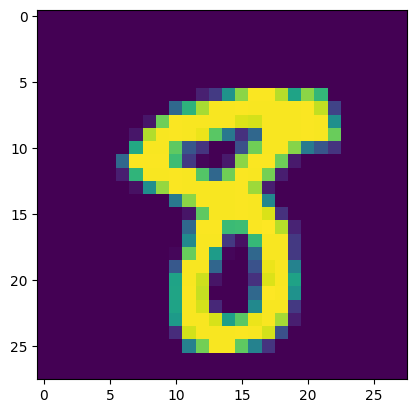

In [10]:
plt.imshow(id_samples[4][0])

In [11]:
ood_batch = next(iter(ood_loader))
ood_samples, ood_targets = ood_batch

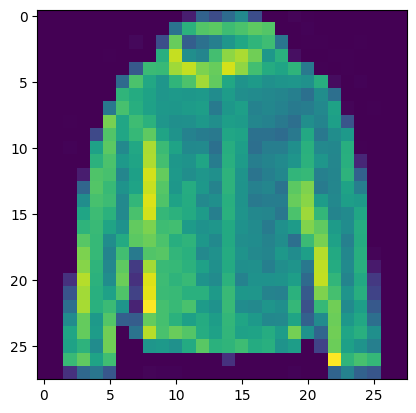

In [12]:
plt.imshow(ood_samples[3][0])

In [13]:
ood_logits = model(ood_samples)
ood_energy = -torch.logsumexp(ood_logits, dim = 1).unsqueeze(1)
ood_scores = ood_detector(ood_energy)
ood_prob = torch.exp(-ood_scores)/(1 + torch.exp(-ood_scores))

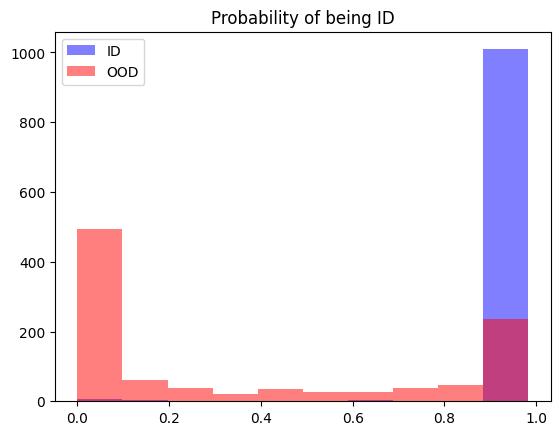

In [14]:
plt.hist(id_prob.cpu().detach().flatten(), color = 'blue', alpha = 0.5, label = "ID")
plt.hist(ood_prob.cpu().detach().flatten(), color = 'red', alpha = 0.5, label = "OOD")
plt.title("Probability of being ID")
plt.legend()
plt.show()

In [146]:
threshold = 0.95 # Rounded from train compute statistics, see `vos_demo.ipynb`

In [147]:
ood_detected_as_ood = [1 if prob < threshold else 0 for prob in ood_prob.detach().flatten()]
ood_detection_acc = sum(ood_detected_as_ood)/len(ood_detected_as_ood)
print(f"OOD Detection Accuracy: {ood_detection_acc}")

OOD Detection Accuracy: 0.8466796875


In [148]:
id_detected_as_ood = [1 if prob < threshold else 0 for prob in id_prob.detach().flatten()]
id_detection_fpr = sum(id_detected_as_ood)/len(id_detected_as_ood)
print(f"False Positive Rate (ID detected as OOD): {id_detection_fpr}")

False Positive Rate (ID detected as OOD): 0.037109375


# Let's inspect the 10 weirdest samples that are ID that look "most OOD"

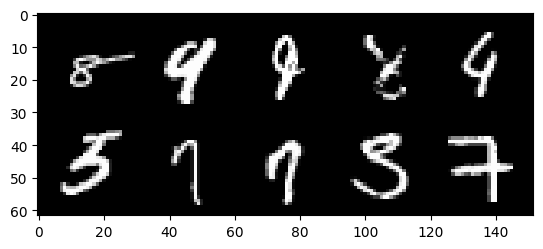

In [135]:
indices = torch.sort(id_prob.flatten()).indices[:10]

grid = torchvision.utils.make_grid(id_samples[indices], nrow = 5, normalize = True)
plt.imshow(grid.permute(1, 2, 0))

# Clearly some are weird. Now let's look at the "most ID" looking OOD samples

Predicted Numbers: tensor([4, 2, 1, 1, 1, 9, 1, 6, 9, 3])


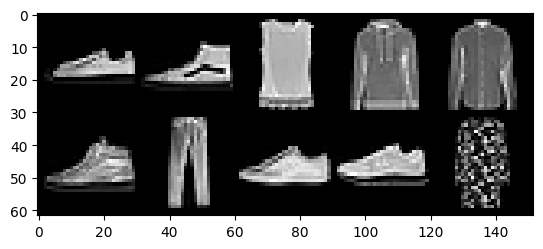

In [145]:
indices = torch.sort(ood_prob.flatten()).indices[-10:]

grid = torchvision.utils.make_grid(ood_samples[indices], nrow = 5, normalize = True)
plt.imshow(grid.permute(1, 2, 0))

predicted_nums = torch.argmax(model(ood_samples[indices]), dim = 1)
print(f"Predicted Numbers: {predicted_nums}")

# What about the most confident ID samples?

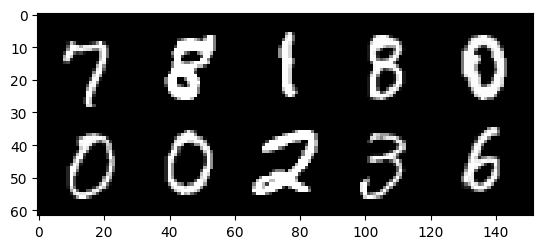

In [137]:
indices = torch.sort(id_prob.flatten()).indices[-10:]

grid = torchvision.utils.make_grid(id_samples[indices], nrow = 5, normalize = True)
plt.imshow(grid.permute(1, 2, 0))

# And the most confident OOD?

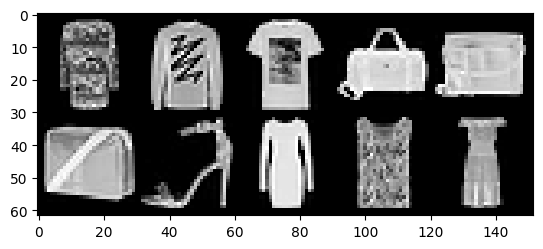

In [139]:
indices = torch.sort(ood_prob.flatten()).indices[:10]

grid = torchvision.utils.make_grid(ood_samples[indices], nrow = 5, normalize = True)
plt.imshow(grid.permute(1, 2, 0))